## Beta-binomial model

Code for implementing the beta-binomial model on the home win rate from the 2020-2021 season of the Premier League using data from: https://www.kaggle.com/datasets/irkaal/english-premier-league-results

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta, binom
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
# Functions for the model
def beta_binomial(previous_count, previous_home_rate, n, y):
    # Given a prior count and rate obtain beta prior parameters
    a = previous_count*previous_home_rate
    b = previous_count*(1 - previous_home_rate)
    assert a/(a+b) == previous_home_rate
    assert a+b == previous_count
    theta = np.linspace(0,1,1000)
    prior = beta.pdf(theta, a, b)
    likelihood = binom.pmf(y, n, theta)    
    posterior = beta.pdf(theta, a + y, b + (n-y))
    return prior, likelihood, posterior

def plot_model(prior, likelihood, posterior, l_scale = 1000, xlim = [0,1], filename = None):
    plt.figure(figsize = (10,6))
    theta = np.linspace(0,1,1000)
    plt.plot(theta, prior, label = "prior")
    # likelihood is scaled by l_scale factor
    plt.plot(theta, l_scale*likelihood, label = "likelihood")
    plt.plot(theta, posterior, label = "posterior")
    plt.xlabel("$\Theta$", fontsize = 12)
    plt.xlim(xlim)
    plt.legend(fontsize=12)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    
def plot_credible_interval(previous_count, previous_home_rate, n, y, prob = 0.95, xlim = [0,1],
                          filename = None):
    a = previous_count*previous_home_rate
    b = previous_count*(1 - previous_home_rate)
    theta = np.linspace(0,1,1000)
    posterior = beta.pdf(theta, a + y, b + (n-y))
    credible_interval = beta.interval(prob, a + y, b + (n-y))
    interval_domain = np.linspace(credible_interval[0], credible_interval[1], 100)
    posterior_interval = beta.pdf(interval_domain, a + y, b + (n-y)) 
    plt.figure(figsize = (10,6))
    plt.plot(theta, posterior)
    plt.fill_between(interval_domain, 0, posterior_interval, alpha = 0.7)
    plt.xlabel("$\Theta$")
    plt.xlim(xlim)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    return credible_interval

def plot_cum_prob(previous_count, previous_home_rate, n, y, q, xlim = [0,1],
                          filename = None):
    a = previous_count*previous_home_rate
    b = previous_count*(1 - previous_home_rate)
    theta = np.linspace(0,1,1000)
    posterior = beta.pdf(theta, a + y, b + (n-y))
    query_domain = np.linspace(0, q, 1000)
    query_density = beta.pdf(query_domain, a + y, b + (n-y))
    plt.figure(figsize = (10,6))
    plt.plot(theta, posterior)
    plt.fill_between(query_domain, 0, query_density, alpha = 0.7)
    plt.xlabel("$\Theta$")
    plt.xlim(xlim)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    return beta.cdf(q, a + y, b + (n-y))

In [3]:
data = pd.read_csv("data/results.csv", encoding = "ISO-8859-1")

In [4]:
# Get data and stats for binomial likelihood
matches_2021 = data.query("Season == '2020-21'")
n = matches_2021.shape[0]
observed_y = (matches_2021.FTR == "H").sum()

In [5]:
# Get historic stats for the prior
previous_home_rate = (data.query("Season in ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20']").FTR == "H").mean()
previous_count = data.query("Season in ['2015-16', '2016-17','2017-18', '2018-19', '2019-20']").shape[0]

In [6]:
print("Historic home win rate: {:.2f}".format(previous_home_rate))
print("Historic number of matches: {}".format(previous_count))

Historic home win rate: 0.46
Historic number of matches: 1900


In [7]:
print("Data home win rate: {:.2f}".format(observed_y/n))
print("Number of matches in data: {}".format(n))

Data home win rate: 0.38
Number of matches in data: 380


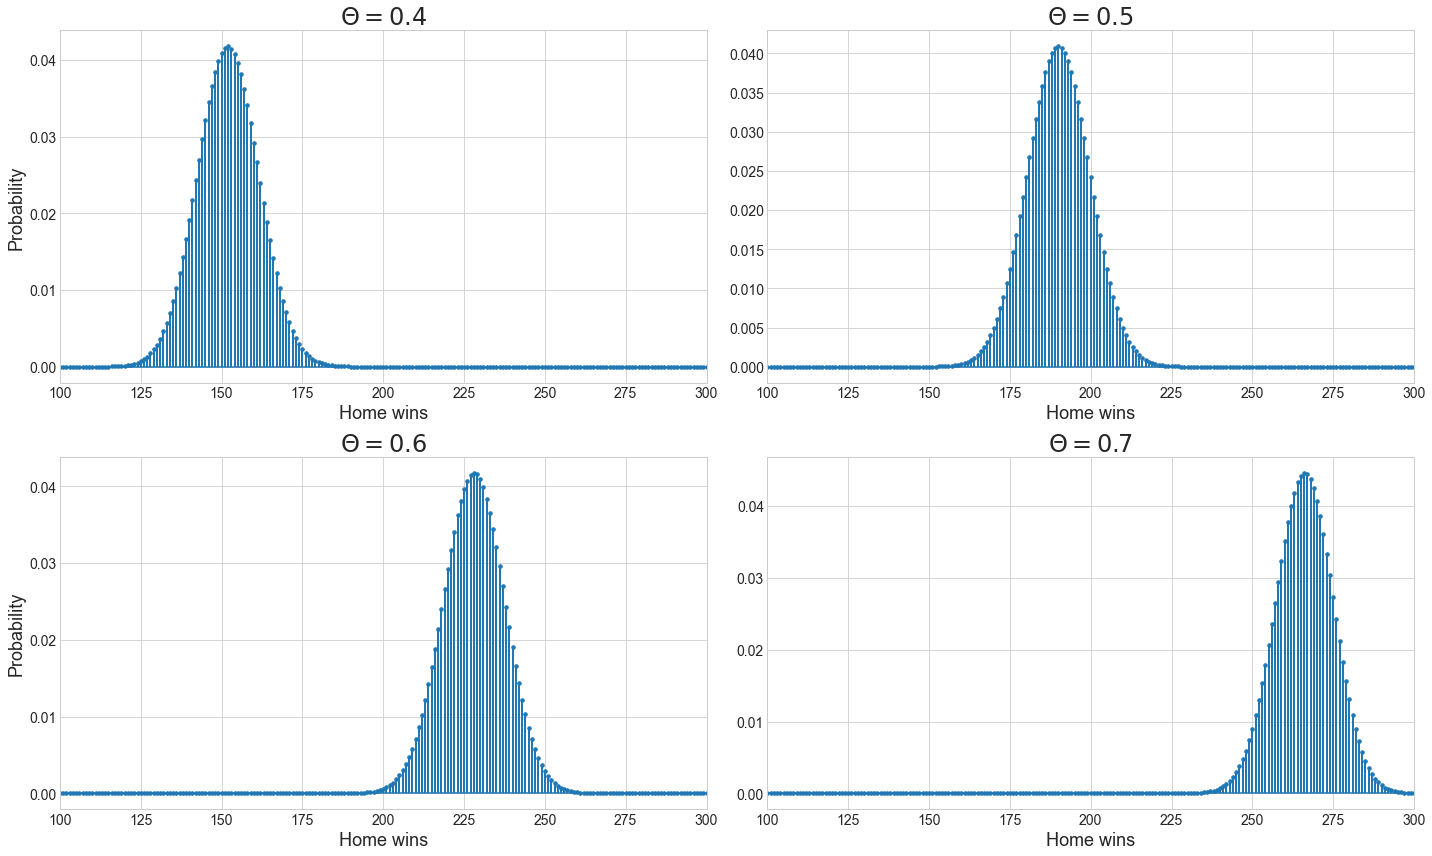

In [8]:
# Visualisation of binomial distribution on Y
y = np.arange(0,n+1)
observed_y = (matches_2021.FTR == "H").sum()
theta_checks = [0.40, 0.50, 0.60, 0.70]
fig, axes = plt.subplots(2,2,figsize = (20,12))
for i, ax in enumerate(axes.flat):
    current_theta = theta_checks[i]
    p_y = binom.pmf(y, n, current_theta)
    markerline, stemlines, baseline  = ax.stem(y, p_y, basefmt = '')
    ax.set_xlabel("Home wins", fontsize=18)
    if i in [0,2]:
        ax.set_ylabel("Probability", fontsize=18)
    ax.set_title("$\Theta = {}$".format(current_theta), fontsize=24)
    ax.set_xlim([100,300])
    #ax.vlines(observed_y, 0, 0.045, colors='k', linestyles='--', label='Observed value')
    #if i == 0:
        #ax.legend(fontsize=16)
    plt.setp(markerline, markersize = 3.5)
    plt.setp(stemlines, linewidth = 2)
    plt.setp(ax.get_xticklabels(), fontsize=14) 
    plt.setp(ax.get_yticklabels(), fontsize=14) 
plt.tight_layout()
plt.show()

## Strong prior model

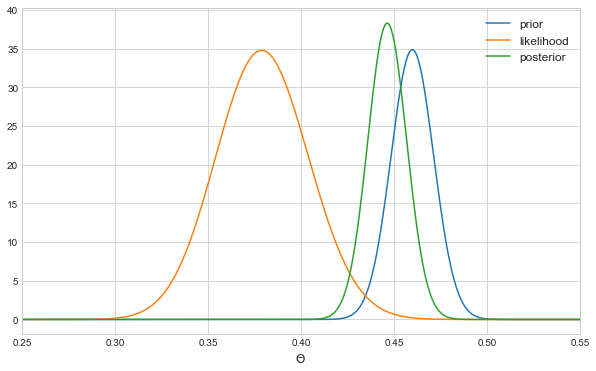

In [9]:
n = matches_2021.shape[0]
y = (matches_2021.FTR == "H").sum()
prior, likelihood, posterior = beta_binomial(previous_count, np.round(previous_home_rate, 2), n, y)
plot_model(prior, likelihood, posterior, l_scale = 825, xlim = [0.25,0.55])

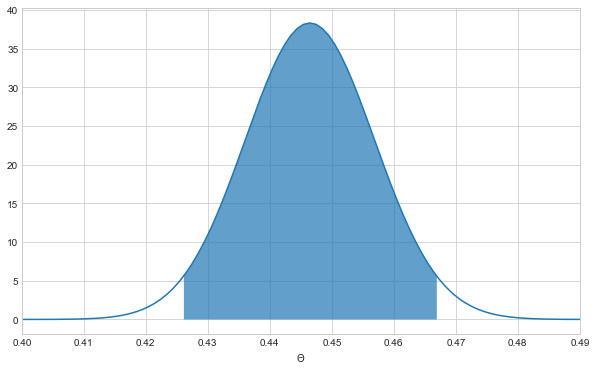

95% credible interval: (0.426, 0.467)


In [10]:
interval = plot_credible_interval(previous_count, np.round(previous_home_rate, 2), n, y, prob = 0.95, xlim = [0.4,0.49])
print("95% credible interval: ({:.3f}, {:.3f})".format(interval[0], interval[1]))

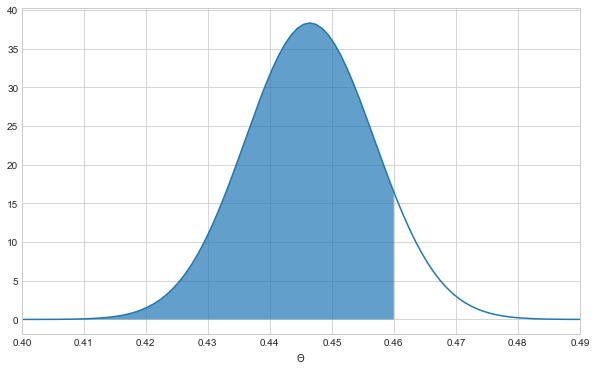

P(rate <= 0.46) = 0.90


In [11]:
prob = plot_cum_prob(previous_count, np.round(previous_home_rate, 2), n, y, 
                     np.round(previous_home_rate, 2), xlim = [0.4,0.49])
print("P(rate <= 0.46) = {:.2f}".format(prob))

## Prior and data weights

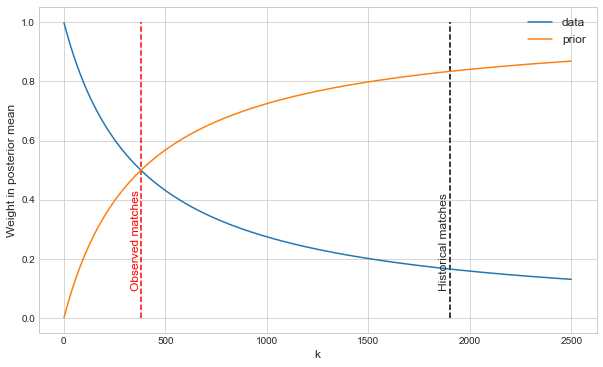

In [12]:
# Get prior and data weights
k = np.arange(1, 2500)
data_weight = n / (n+k)
prior_weight = k / (n+k)
plt.figure(figsize = (10,6))
plt.plot(k, data_weight, label = "data")
plt.plot(k, prior_weight, label = "prior")
plt.vlines(previous_count, 0,1, color = "k", linestyle = "--")
plt.text(previous_count - 50,0.1,'Historical matches',rotation=90, fontsize = 12)
plt.vlines(380, 0,1, color = "r", linestyle = "--")
plt.text(330,0.1,'Observed matches',color="r",rotation=90, fontsize = 12)
plt.legend(fontsize=12)
plt.xlabel("k", fontsize = 12)
plt.ylabel("Weight in posterior mean", fontsize = 12)
plt.show()

## Balanced model

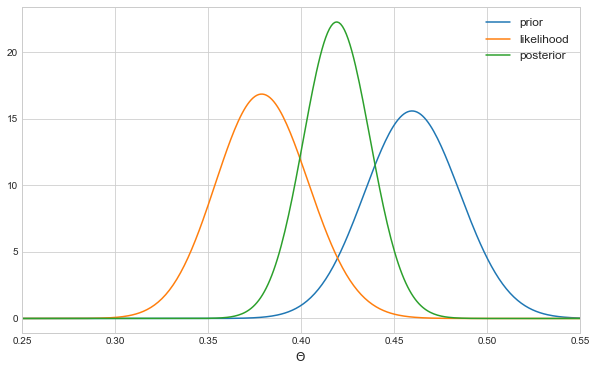

In [13]:
prior, likelihood, posterior = beta_binomial(n, np.round(previous_home_rate, 2), n, y)
plot_model(prior, likelihood, posterior, l_scale =400, xlim = [0.25,0.55])

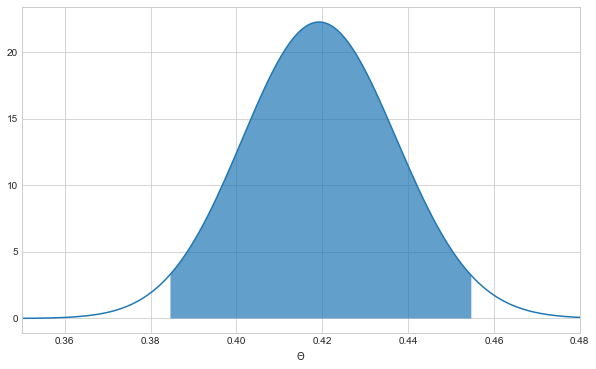

95% credible interval: (0.385, 0.455)


In [14]:
interval = plot_credible_interval(n, np.round(previous_home_rate, 2), n, y, prob = 0.95, xlim = [0.35,0.48])
print("95% credible interval: ({:.3f}, {:.3f})".format(interval[0], interval[1]))

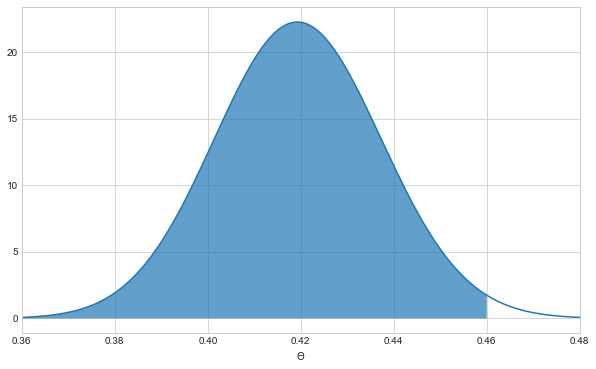

P(rate <= 0.46) = 0.99


In [15]:
prob = plot_cum_prob(n, np.round(previous_home_rate, 2), n, y, 
                     np.round(previous_home_rate, 2), xlim = [0.36,0.48])
print("P(rate <= 0.46) = {:.2f}".format(prob))

## Flat prior model

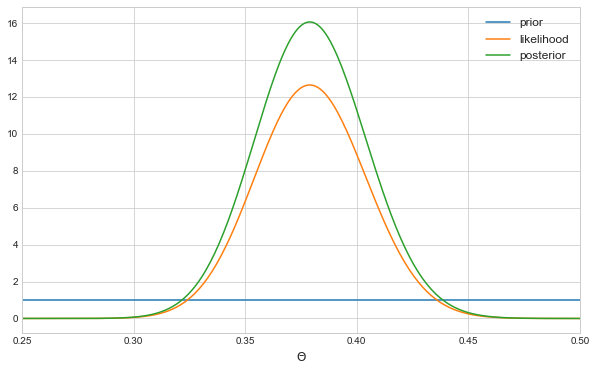

In [16]:
prior, likelihood, posterior = beta_binomial(2, 0.50, n, y)
plot_model(prior, likelihood, posterior, l_scale =300, xlim = [0.25,0.5])

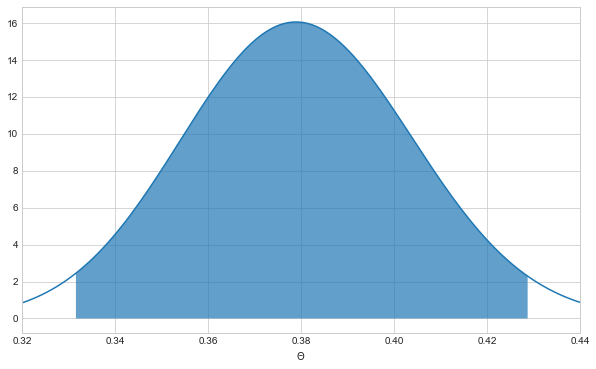

95% credible interval: (0.332, 0.429)


In [17]:
interval = plot_credible_interval(2, 0.5, n, y, prob = 0.95, xlim = [0.32,0.44])
print("95% credible interval: ({:.3f}, {:.3f})".format(interval[0], interval[1]))

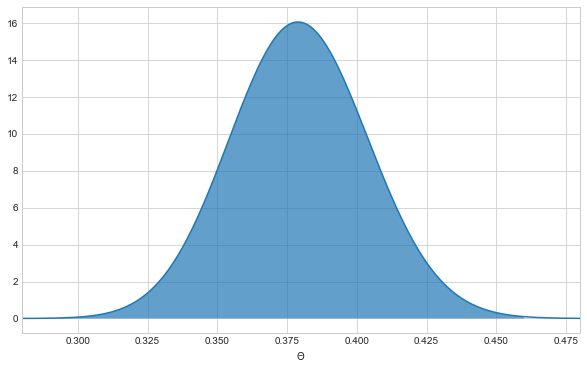

P(rate <= 0.46) = 1.00


In [18]:
prob = plot_cum_prob(2, 0.5, n, y,  np.round(previous_home_rate, 2), xlim = [0.28,0.48])
print("P(rate <= 0.46) = {:.2f}".format(prob))